# Exploring Spotify Listening History

## A Quarantine Project

#### In the summer of 2017, I created a last.fm account (https://www.last.fm/user/gps56) in order to record my listening habits on Spotify.  Last.fm allows you to link music streaming services, and serves to record your listens (referred to as 'scrobbles').  You can download your data to csv, or use last.fm's API to pull it directly.  

#### Over the past few weeks I used my free time in quarantine to take a peek into my listening habits.  I had 3 years of listening history and almost song listens to wade through.  Take a look!

First, importing packages I used.

I primarily used `pandas` for interacting with the data.  `pandas` has a weird quirk where it warns you whenever you create a new column as a reference to a previous one.  This can get messy if you're going to be mangling columns, but if you're mostly just creating new columns and leaving previous ones untouched, you can turn off the warning.

In [9]:
import os, sys
import pandas as pd, numpy as np
import datetime, time

# turn off SettingwithCopyWarning
pd.options.mode.chained_assignment = None

I downloaded my scrobbling history to a csv.  Read into a `pandas` `DataFrame` as usual.  The flat file contains artist/album/song along with the date/time of each listen.

In [10]:
__scrobbles__ = 'downloads/gps56-2.csv'

df = pd.read_csv(__scrobbles__, header = None, names = ['artist', 'album', 'song', 'datetime'])

#### Some preliminary preprocessing

Remove any records that have blank date/time info (there should only be a negligible amount).
The date/time column is given in UTC.  Since I've spent the past 3 years living in NYC, I'll subtract 5 hours from this.

In [11]:
df.datetime.isna().value_counts()

False    55281
True       277
Name: datetime, dtype: int64

In [12]:
# remove NaN datetimes
df = df[~df.datetime.isna()]

In [18]:
df.datetime = pd.to_datetime(df.datetime, utc = True).dt.tz_convert('US/Eastern')

Here's what the most recent listens are (at the time of downloading the data).

In [19]:
df.head(10)

,artist,album,song,datetime
1,Drake,Dark Lane Demo Tapes,Pain 1993 (with Playboi Carti),2020-05-04 20:34:00-04:00
2,Juice WRLD,Death Race For Love,Empty,2020-05-04 18:07:00-04:00
3,Juice WRLD,Death Race For Love,Rider,2020-05-04 18:05:00-04:00
4,Juice WRLD,Death Race For Love,Make Believe,2020-05-04 18:05:00-04:00
5,Juice WRLD,Death Race For Love,She’s The One,2020-05-04 17:58:00-04:00
6,Juice WRLD,Death Race For Love,10 Feet,2020-05-04 17:56:00-04:00
7,Juice WRLD,Death Race For Love,Ring Ring (with Rvssian feat. Clever),2020-05-04 17:53:00-04:00
8,Juice WRLD,Death Race For Love,Maze,2020-05-04 17:50:00-04:00
9,Juice WRLD,Death Race For Love,Empty,2020-05-04 17:46:00-04:00
10,Juice WRLD,Death Race For Love,Make Believe,2020-05-04 17:44:00-04:00


# Time Analysis

### Checking out my listening habits throughout the days, weeks, and years.  Made some plots too.

Using `matplotlib` is a given, and `seaborn` gives us a nice wrapper with cleaner syntax and some nice themes.

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid", color_codes = True)

# these lists with proper order will come in handy later ... 
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

### Let's get some basic metrics out of the way.

The total number of listens is just the length of the dataframe.

In [21]:
total_listens = len(df)
print(total_listens, 'total listens')

55281 total listens


The number of days I listened to music is the length of the deduplicated date column.

In [22]:
unique_days = len(df.datetime.dt.date.drop_duplicates())
print(unique_days, 'days with a listen recorded')

972 days with a listen recorded


Those are only days that I listened to music -- there were definitely days where I didnt listen to anything.
To get total days elapsed, I take the difference between the `max` and `min` of the date column.

In [23]:
all_days = (df.datetime.dt.date.max() - df.datetime.dt.date.min()).days
passive_days = all_days - unique_days
print("{} days elapsed; {} days without a listen".format(all_days, passive_days))

1040 days elapsed; 68 days without a listen


Similarly, we can get the number of 'active' weeks by grouping the dataframe by year and week, then taking length of the resulting `groupby` object.  This is an easy way to get the number of unique combinations of two separate derived series in situ. 


In [24]:
unique_weeks = len(df.groupby([df.datetime.dt.year, df.datetime.dt.week]))
print(unique_weeks, 'active weeks')

148 active weeks


First, lets take a look at how my total listens are divided by day.

In [25]:
mean_listens_per_day_active = total_listens/unique_days
mean_listens_per_day_total = total_listens/all_days
print("{} listens on an active day; {} listens per day overall".format(*map(lambda x: round(x, 1), [mean_listens_per_day_active, mean_listens_per_day_total])))

56.9 listens on an active day; 53.2 listens per day overall


Looking at average listens per week.

In [26]:
mean_listens_per_week = total_listens/unique_weeks
print("{} listens in an average week".format(round(mean_listens_per_week, 1)))

373.5 listens in an average week


Now we can dive into seeing how my listens are distributed in an average week.  These types of series views will be easily plotted later on.

In [27]:
day_counts = df.datetime.dt.day_name().value_counts().reindex(day_order)
day_counts

Monday       7205
Tuesday      9337
Wednesday    7830
Thursday     9405
Friday       9691
Saturday     6964
Sunday       4849
Name: datetime, dtype: int64

This is nice, but a more useful metric might be the fraction of each rather than total count.
here's a simple function that takes a `pd.Series` of integers as its input and returns the series back with float percentages.

In [28]:
def get_percents(value_counts):
    # convert value counts series to percentages
    value_counts /= value_counts.sum()
    value_counts = value_counts.round(3)*100
    return value_counts

In [29]:
day_counts_percent = get_percents(day_counts)
day_counts_percent

Monday       13.0
Tuesday      16.9
Wednesday    14.2
Thursday     17.0
Friday       17.5
Saturday     12.6
Sunday        8.8
Name: datetime, dtype: float64

Similarly, we can get the percent of total listens per month.

In [30]:
month_counts_percent = get_percents(df.datetime.dt.month_name().value_counts().reindex(month_order))
month_counts_percent

January       9.2
February      8.4
March        10.5
April         7.2
May           4.1
June          5.6
July          7.4
August       10.8
September     9.2
October       9.7
November      9.3
December      8.5
Name: datetime, dtype: float64

This is just the number of listens on each day.  Plotting this will allow us to see my daily listens trending over time.

In [31]:
individual_day_counts = df.datetime.dt.date.value_counts().sort_index()
individual_day_counts_percent = get_percents(df.datetime.dt.date.value_counts())
individual_day_counts

2017-06-29     2
2017-07-01     1
2017-07-04    11
2017-07-05    34
2017-07-06    60
              ..
2020-04-30    67
2020-05-01    78
2020-05-02    26
2020-05-03    44
2020-05-04    57
Name: datetime, Length: 972, dtype: int64

While we can plot this outright, it's likely that there will be a lot of noise as my listening habits are likely not perfectly consistent day to day.
As a solution, I'll compute a few rolling average series -- 10-day, 30-day, and 90-day.  I concatenate these into a single dataframe for ease of plotting.

In [32]:
to_plot = {'Raw': individual_day_counts,
        '10-day': individual_day_counts.rolling(10).mean(),
        '30-day': individual_day_counts.rolling(30).mean(),
        '90-day': individual_day_counts.rolling(90).mean()}

multiline_plot_df = pd.concat(to_plot.values(), axis = 1)
multiline_plot_df.columns = to_plot.keys()
multiline_plot_df

,Raw,10-day,30-day,90-day
2017-06-29,2,NaN,NaN,NaN
2017-07-01,1,NaN,NaN,NaN
2017-07-04,11,NaN,NaN,NaN
2017-07-05,34,NaN,NaN,NaN
2017-07-06,60,NaN,NaN,NaN
...,...,...,...,...
2020-04-30,67,92.4,59.400000,70.855556
2020-05-01,78,86.0,60.933333,71.000000
2020-05-02,26,60.0,59.500000,69.866667
2020-05-03,44,58.0,59.500000,69.177778


# Plots

This is a custom function which allows the user to obtain a stratified color palette based on the data they input.  In this case, low values recieve a color from one end of the palette's spectrum, while high values receive colors from the opposite end.  As you can guess, this is useful in bar plots to make high or low values stand out.

In [33]:
# function to set colors according to values in barplot
def colors_from_values(values, palette_name = "YlGnBu"):
    normalized = (values - values.min()) / (values.max() - values.min())
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

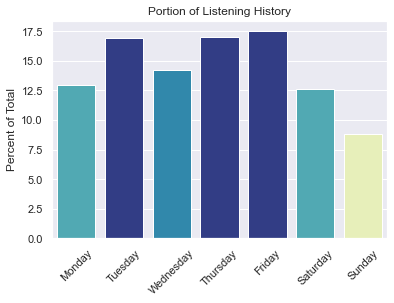

In [34]:
plt.figure()
sns.barplot(day_counts_percent.index, day_counts_percent.values, palette = colors_from_values(day_counts_percent.values))
plt.title('Portion of Listening History')
plt.ylabel('Percent of Total', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Above is the plot of the fraction of listening per day.  The general trend is that I listen to music more when I'm working during the week.  Saturdays have a healthy amount of listening, while Sundays are very inactive.

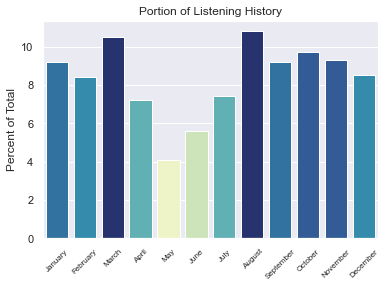

In [36]:
plt.figure()
sns.barplot(x = month_counts_percent.index, y = month_counts_percent.values, palette = colors_from_values(month_counts_percent.values))
plt.title('Portion of Listening History')
plt.ylabel('Percent of Total', fontsize=12)
plt.xticks(rotation=45, fontsize = 8)
plt.show()

This plot shows the fraction of listening split by month.  Not really sure if I hoped to see any trends here, since I would expect my listening habits to remain relatively throughout the year.  However, it is clear that May is slacking a bit -- after looking into this, I found out that ~half of my listening data in May 2018 was not recorded.  Let's take a look at 2019 only to see if it's more consistent across the board.

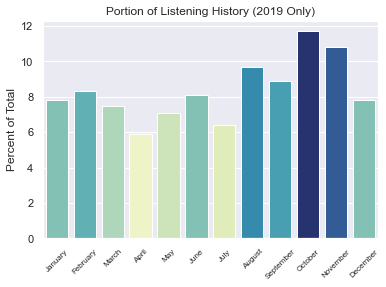

In [37]:
month_counts_percent_2019 = get_percents(df[df.datetime.dt.year == 2019].datetime.dt.month_name().value_counts().reindex(month_order))

plt.figure()
sns.barplot(x = month_counts_percent_2019.index, y = month_counts_percent_2019.values, palette = colors_from_values(month_counts_percent_2019.values))
plt.title('Portion of Listening History (2019 Only)')
plt.ylabel('Percent of Total', fontsize=12)
plt.xticks(rotation=45, fontsize = 8)
plt.show()

Not much to glean here other than the fact that I listened to a lot more music in the fall.  If I recall, I was very busy at work these months, so I guess the trend makes sense.

In [38]:
october_2019 = df[(df.datetime.dt.year == 2019) & (df.datetime.dt.month == 10)]
october_2019_listens = len(october_2019)
october_2019_most_listens = max(october_2019.datetime.dt.day.value_counts())
print(october_2019_listens, 'total listens in October 2019')
print('Highest amount of listens in one day:', october_2019_most_listens)

2763 total listens in October 2019
Highest amount of listens in one day: 239


Very likely that I fell asleep with a playlist on repeat on that day with 239 listens.

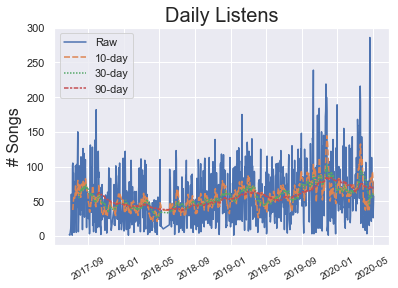

In [39]:
plt.figure()
sns.lineplot(data = multiline_plot_df)
plt.title('Daily Listens', fontsize = 20)
plt.ylabel('# Songs', fontsize=16)
plt.xticks(rotation=30, fontsize = 10)
plt.show()

This plot shows my daily listening trends since summer 2017.  Rolling averages are the dashed lines.

As expected, the raw data has too much noise to gather meaningful information from (you can even see in May 2018 where no data was recorded).  The rolling average lines do a good job of showing the general trend (the fall 2019 bump in activity is apparent as identified earlier).

## Most popular times

Now that we've seen my listening habits across days/months/years, let's dive into the daily breakdown.

In [40]:
# this will come in handy later ... 
hour_map = {0: '12 AM',
 1: '1 AM',
 2: '2 AM',
 3: '3 AM',
 4: '4 AM',
 5: '5 AM',
 6: '6 AM',
 7: '7 AM',
 8: '8 AM',
 9: '9 AM',
 10: '10 AM',
 11: '11 AM',
 12: '12 PM',
 13: '1 PM',
 14: '2 PM',
 15: '3 PM',
 16: '4 PM',
 17: '5 PM',
 18: '6 PM',
 19: '7 PM',
 20: '8 PM',
 21: '9 PM',
 22: '10 PM',
 23: '11 PM'}

Below, I gather the total listens per hour, then divide by the number of active days to get a view of average daily listens per hour.  

In [41]:
hour_counts = df.datetime.dt.hour.value_counts().sort_index().rename(hour_map)
average_hour_counts = hour_counts/unique_days
average_hour_counts

12 AM    1.295267
1 AM     0.869342
2 AM     0.727366
3 AM     0.669753
4 AM     0.657407
5 AM     0.576132
6 AM     0.795267
7 AM     0.371399
8 AM     1.124486
9 AM     3.805556
10 AM    2.173868
11 AM    2.550412
12 PM    2.531893
1 PM     3.834362
2 PM     4.236626
3 PM     4.070988
4 PM     3.825103
5 PM     4.145062
6 PM     5.454733
7 PM     3.839506
8 PM     3.095679
9 PM     2.517490
10 PM    2.090535
11 PM    1.615226
Name: datetime, dtype: float64

Before plotting, I create a new palette which maps the 'twilight_shifted' palette to the index (hours) to give a nice color gradient across the day.

In [42]:
day_palette = colors_from_values(np.array(list(hour_map.keys())), palette_name = 'twilight_shifted')

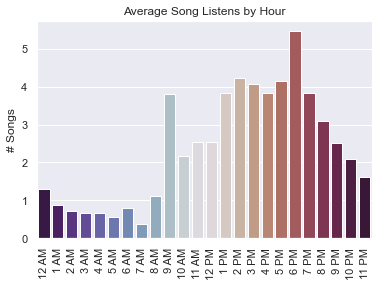

In [43]:
plt.figure()
sns.barplot(x = average_hour_counts.index, y = average_hour_counts.values, palette = day_palette)
plt.title('Average Song Listens by Hour')
plt.ylabel('# Songs', fontsize=12)
plt.xticks(rotation=90)
plt.show()

As expected, its unlikely for me to be listening to music in the middle of the night.  The first spike occurs at 9AM, when I'm commuting.  There appears to be a lull in the mid-morning as I get caught up in work and meetings.  There's a general trend upward post-lunch as I likely settle in at my desk, and then another spike around 6PM when I begin my commute home.  I also tend to keep music on after I get home, when making dinner, doing chores, etc.

These are general trends, since they encapsulate all days of the week.  My commuting habits dominate the view since they are roughly 5/7ths of my listening history.  To get a more granular view, let's look at the hourly breakdown by day.

## Hour breakdown, split by days

In [44]:
# grouping the dataframe based on day name 
grouped_days = df.groupby(df.datetime.dt.day_name())
# make sure the groupby index are sorted in the proper order of days 
grouped_days = sorted(grouped_days, key = lambda x: day_order.index(x[0]))

In [45]:
# get number of instances of each day
n_days = pd.to_datetime(df.datetime.dt.date.drop_duplicates()).dt.day_name().value_counts()
n_days

Wednesday    143
Monday       140
Thursday     140
Tuesday      139
Friday       139
Saturday     137
Sunday       134
Name: datetime, dtype: int64

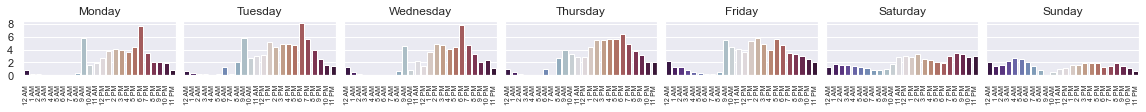

In [49]:
fig, axes = plt.subplots(nrows = 1, ncols = len(grouped_days), sharey = True, figsize=(20,1))
fig.subplots_adjust(wspace = 0.05)

plt.yticks(np.arange(0, max(hour_counts)/max(n_days), 2))
# plt.ylabel('# Songs', fontsize=12)

for ax, (day, sub_df) in zip(axes, grouped_days):
    # get daily hour counts, rename to readable hours (ex. '2 PM'), and sort in the proper manner
    day_hour_counts = sub_df.datetime.dt.hour.map(hour_map).value_counts().reindex(hour_map.values())
    # divide by number of instances of that day in order to get average daily counts 
    day_hour_counts /= n_days.loc[day]

    ax.set_title(day.capitalize())
    ax.tick_params(axis = 'x', rotation = 90, labelsize = 7)
    ax.set_xticklabels(['12AM', '6AM', '12PM', '6PM'])
    sns.barplot(x = day_hour_counts.index, y = day_hour_counts.values, ax = ax, palette = day_palette)

plt.show()

Above is the listening distribution for each day.  As expected, weekdays show mostly the same pattern.  Earlier in the week, I'm less likely to be listening to music at night.  On Tuesdays/Thursdays there is some volume at 6AM due to waking up early to go swim.  Friday and particularly Saturday nights have volume throughout the night.

# artist analysis

Let's take a look at some of my most played artists and songs.

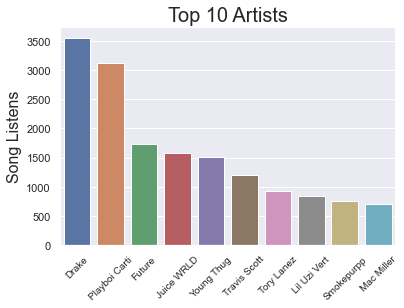

In [54]:
top_10_artists = df.artist.value_counts().head(10)

plt.figure()
sns.barplot(x = top_10_artists.index, y = top_10_artists.values, )
plt.title('Top 10 Artists', fontsize = 20)
plt.ylabel('Song Listens', fontsize=16)
plt.xticks(rotation=45, fontsize = 10)
plt.show()

Who doesn't like Drake?  A close second is Playboi Carti.

As this is only a simple view, it doesn't tell the full story of _when_ I listened to these artists over time.  We can do this by isolating my listening history to each artist, and then plotting the individual time series to see how my interest evolved over time.

First, let's define a simple function that returns the time series for a given artist.

In [55]:
def get_artist_series(df, artist):
    return df[df.artist.str.contains(artist)].datetime.dt.date.value_counts().sort_index()

In [56]:
get_artist_series(df, 'Mac Miller')

2017-07-17    4
2017-07-18    1
2017-07-20    1
2017-07-21    1
2017-07-26    1
             ..
2020-04-13    2
2020-04-20    1
2020-04-24    2
2020-04-27    1
2020-04-28    1
Name: datetime, Length: 161, dtype: int64

This shows the number of times I listened to Mac Miller on each day.  Similar to our earlier analysis, it might be more useful to use a rolling average to view trends more cleanly.

Below, I'll create a dataframe with a 60-day rolling average time series for my top 5 most played artists.  Days where no listens were recorded for that artist will have a `NaN`

In [57]:
top_5_artists = df.artist.value_counts().head(5)

to_plot_artists = {artist: get_artist_series(df, artist).rolling(60).mean() for artist in top_5_artists.index}

multiline_plot_df_artist = pd.concat(to_plot_artists.values(), axis = 1).sort_index()
multiline_plot_df_artist.columns = to_plot_artists.keys()
multiline_plot_df_artist

,Drake,Playboi Carti,Future,Juice WRLD,Young Thug
2017-07-01,NaN,NaN,NaN,NaN,NaN
2017-07-04,NaN,NaN,NaN,NaN,NaN
2017-07-05,NaN,NaN,NaN,NaN,NaN
2017-07-06,NaN,NaN,NaN,NaN,NaN
2017-07-07,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-04-30,NaN,6.766667,NaN,5.883333,3.833333
2020-05-01,10.950000,NaN,5.716667,NaN,NaN
2020-05-02,10.866667,NaN,5.766667,NaN,NaN
2020-05-03,10.183333,NaN,5.800000,NaN,NaN


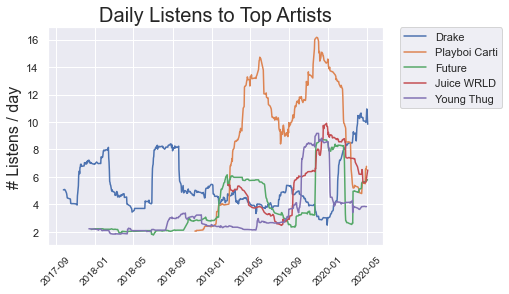

In [58]:
plt.figure()
sns.lineplot(data = multiline_plot_df_artist, dashes = False,)
plt.title('Daily Listens to Top Artists', fontsize = 20)
plt.ylabel('# Listens / day', fontsize=16)
plt.xticks(rotation=45, fontsize = 10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Here, we can see how much I listened to each individual artist over time.  

Clearly, Drake has always been a favorite, and gets consistent listens with some periods of elevated interest.  In the summer of 2018, you can see an elevated plateau which coincides with the release of his June 2018 album _Scorpion_.

Future and Young Thug have similar patterns, with consistent interest and brief periods of high-volume listening.  You can see a spike in listening to Future right at the beginning of 2019 which coincides with the release of his album _The Wizrd_.  Similarly, for Young Thug, there's a spike around September 2019 which falls right after the release of his album _So Much Fun_.

A standout here is Playboi Carti, and artist that I didn't start heavily listening to until around the beginning of 2019.  Evidently, my interest quickly outshined that in other artists and remained mostly throughout the past year despite him not releasing any other music (read:  I was listening to his two albums over and over).  Interest has waned over the past few months, but still remains up there with other artists.

Now let's take a look at my favorite songs in a similar fashion.  Similar to before, I can define a simple function to get the time series for a given song.

In [59]:
def get_song_series(df, song):
    return df[df.song == song].datetime.dt.date.value_counts().sort_index()

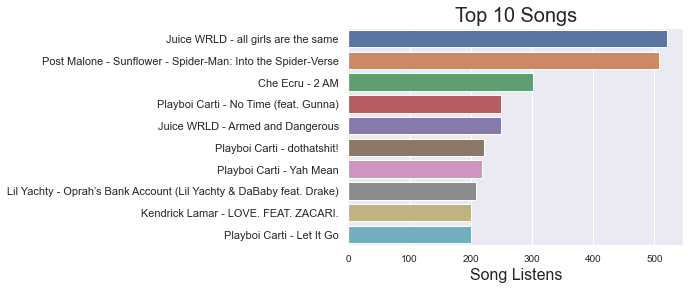

In [61]:
top_10_songs = df.groupby([df.song, df.artist]).size().sort_values(ascending = False).head(10)

plt.figure()
song_titles = ['{} - {}'.format(artist, song) for song, artist in top_10_songs.index]
sns.barplot(y = song_titles, x = top_10_songs.values, orient = 'h')
plt.title('Top 10 Songs', fontsize = 20)
plt.xlabel('Song Listens', fontsize=16)
plt.xticks(rotation=0, fontsize = 10)
plt.show()

As you can see, Juice WRLD and Carti exist in my top artists mainly due to me listening to a few of their songs disproportionately -- Drake, Future, and Young Thug do not have any songs in my top 10.

I can personally attest to falling asleep leaving the spiderman/sunflower song on during two separate occasions ... 

Next, similar to with the artists, we can take a look at how I listened to these top songs over time.  This time I'll use a 15-day rolling average.

In [68]:
top_5_songs = df.groupby([df.song, df.artist]).size().sort_values(ascending = False).head(5)

to_plot_songs = {'{} - {}'.format(artist, song): get_song_series(df, song).rolling(15).mean() for song, artist in top_5_songs.index}

multiline_plot_df_songs = pd.concat(to_plot_songs.values(), axis = 1).sort_index()
multiline_plot_df_songs.columns = to_plot_songs.keys()

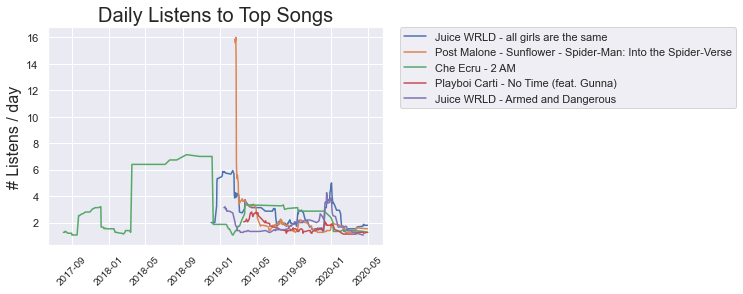

In [69]:
plt.figure()
sns.lineplot(data = multiline_plot_df_songs, dashes = False,)
plt.title('Daily Listens to Top Songs', fontsize = 20)
plt.ylabel('# Listens / day', fontsize=16)
plt.xticks(rotation=45, fontsize = 10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

As mentioned, the spiderman/sunflower song suffered from massive overplaying when I initially found it, then interest tapered off.

Looking at the graph, it appears that (save for a few random spikes), many of these songs get consistent, low-volume interest over time.  I still listen to all of these songs regularly!

# Spotify exploration

## For another part of my project, I explored what the Spotify API had to offer.  

In particular, the Spotify API allows you to pull 'features' for each song.  A summary of these features can be seen in the documentation [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/).

These features are mainly continuous values between 0 and 1.  While Spotify gives a description of each, we don't know exactly how they are calculated, so it's hard to glean much information here.  Nevertheless, let's check it out.

I had previously scraped the data for all the songs in my last.fm history using the Spotify API.  The scraping modules live in this repo on my github.

In [83]:
# read in spotify features from scraping json output
sp_features = pd.read_json("scraping/output/spotify/completed.json", orient = 'table')

# convert dict series to dataframe
sp_features = sp_features.spotify.apply(pd.Series)
sp_features.sample(5)

,,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
artist,song,,,,,,,,,,,,,,,,,,
A$AP Rocky,Tony Tone,0.534,0.783,1,-4.013,1,0.2610,0.1390,0.00000,0.0831,0.334,69.716,audio_features,52eYVUkFTOVozbVFIaFrnV,spotify:track:52eYVUkFTOVozbVFIaFrnV,https://api.spotify.com/v1/tracks/52eYVUkFTOVo...,https://api.spotify.com/v1/audio-analysis/52eY...,208373,4
Ghost Loft,Burn Slow,0.540,0.557,7,-4.773,0,0.0264,0.0297,0.01350,0.1890,0.296,76.979,audio_features,3uj0tBe9BhI64RiOzzoPQv,spotify:track:3uj0tBe9BhI64RiOzzoPQv,https://api.spotify.com/v1/tracks/3uj0tBe9BhI6...,https://api.spotify.com/v1/audio-analysis/3uj0...,203050,4
TroyBoi,ili,0.634,0.588,9,-6.753,1,0.1060,0.0575,0.00231,0.4410,0.770,174.006,audio_features,59QmjU5K8XQTfj9JjFNb4Z,spotify:track:59QmjU5K8XQTfj9JjFNb4Z,https://api.spotify.com/v1/tracks/59QmjU5K8XQT...,https://api.spotify.com/v1/audio-analysis/59Qm...,245000,4
Travis Thompson,Bad Apples,0.655,0.661,7,-7.383,1,0.3290,0.1200,0.00000,0.0980,0.366,146.977,audio_features,7EA8f3thnYSRAzlKBsyUdi,spotify:track:7EA8f3thnYSRAzlKBsyUdi,https://api.spotify.com/v1/tracks/7EA8f3thnYSR...,https://api.spotify.com/v1/audio-analysis/7EA8...,219573,4
Quavo,FLIP THE SWITCH (feat. Drake),0.853,0.637,3,-5.924,0,0.3310,0.1290,0.00000,0.2670,0.496,86.048,audio_features,1rlIrbWboTRGeKfHhgbJRZ,spotify:track:1rlIrbWboTRGeKfHhgbJRZ,https://api.spotify.com/v1/tracks/1rlIrbWboTRG...,https://api.spotify.com/v1/audio-analysis/1rlI...,156195,4


Here, you can see the result of my scraping, along with a sample view of 5 random rows.  These are all the columns you receive when you make a query for audio features.

Next, let's merge the the original `df` from before, containing all my listening history, with this lookup of audio features.


In [84]:
# merge with listening dataframe on artist/song 
merged = df.merge(sp_features, left_on = ['artist', 'song'], right_index = True, how = 'left')
merged.head(5)

,artist,album,song,datetime,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
1,Drake,Dark Lane Demo Tapes,Pain 1993 (with Playboi Carti),2020-05-04 20:34:00-04:00,0.825,0.373,5.0,-5.532,0.0,0.1080,...,0.368,0.120,77.271,audio_features,6Kj17Afjo1OKJYpf5VzCeo,spotify:track:6Kj17Afjo1OKJYpf5VzCeo,https://api.spotify.com/v1/tracks/6Kj17Afjo1OK...,https://api.spotify.com/v1/audio-analysis/6Kj1...,149078.0,4.0
2,Juice WRLD,Death Race For Love,Empty,2020-05-04 18:07:00-04:00,0.745,0.561,0.0,-4.869,1.0,0.0807,...,0.133,0.449,77.557,audio_features,41MCdlvXOl62B7Kv86Bb1v,spotify:track:41MCdlvXOl62B7Kv86Bb1v,https://api.spotify.com/v1/tracks/41MCdlvXOl62...,https://api.spotify.com/v1/audio-analysis/41MC...,248431.0,4.0
3,Juice WRLD,Death Race For Love,Rider,2020-05-04 18:05:00-04:00,0.583,0.815,7.0,-4.257,1.0,0.0365,...,0.413,0.451,140.031,audio_features,3usM520kfIRpWNaYOwdnYI,spotify:track:3usM520kfIRpWNaYOwdnYI,https://api.spotify.com/v1/tracks/3usM520kfIRp...,https://api.spotify.com/v1/audio-analysis/3usM...,192094.0,4.0
4,Juice WRLD,Death Race For Love,Make Believe,2020-05-04 18:05:00-04:00,0.465,0.840,0.0,-4.350,1.0,0.0722,...,0.138,0.672,83.981,audio_features,6eiztdXRkooWsBt2xToMWI,spotify:track:6eiztdXRkooWsBt2xToMWI,https://api.spotify.com/v1/tracks/6eiztdXRkooW...,https://api.spotify.com/v1/audio-analysis/6eiz...,142026.0,4.0
5,Juice WRLD,Death Race For Love,She’s The One,2020-05-04 17:58:00-04:00,0.621,0.804,6.0,-5.502,0.0,0.2250,...,0.297,0.396,155.984,audio_features,3zM2prB16NRn1zggh1KCY0,spotify:track:3zM2prB16NRn1zggh1KCY0,https://api.spotify.com/v1/tracks/3zM2prB16NRn...,https://api.spotify.com/v1/audio-analysis/3zM2...,188837.0,4.0


_(Note that I'm just merging and not deduplicating here -- the idea being that even if I listen to the same song many times in a row, its audio features should carry the appropriate 'weight' in the dataset)_

First let's check out statistics about the duration of songs I listen to.  Probably nothing interesting here, but I've always been curious.

Let's look at a distribution plot of the durations in seconds.

Mean duration: 3.5 min


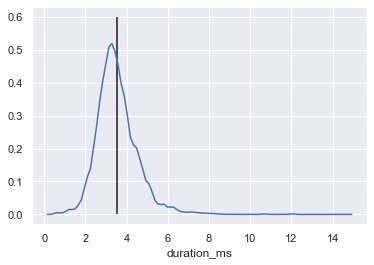

In [97]:
# divide by 60000 to convert to minutes
sns.distplot((merged.duration_ms/60000), hist = False)
mean_duration = (merged.duration_ms/60000).mean()
plt.vlines(mean_duration, ymin = 0, ymax = 0.6)
# plt.show()
print("Mean duration:", round(mean_duration, 1), "min")

As expected, nothing interesting.  Looks like it follows a relatively normal distribution, with the mean right around 3.5 min.  

This doesn't mean much in and of itself, but I could be interested in how this compares to other people's listening habits.  To get a good grasp on how my stats stack up to other peoples', I can pull the US Top 50 playlist from Spotify, gather the audio features of these songs, then compare to mine.

To get the content of the US Top 50 playlist and then scrape the audio features, I again use the API.  I built a method in my `Spotify` class, which can be seen on my github.  It returns a dataframe directly.

In [99]:
from scraping.spotify import Spotify

df_top50 = Spotify.get_top50_features()
df_top50.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.746,0.690,11,-7.956,1,0.1640,0.24700,0.000000,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4
1,0.716,0.537,0,-7.648,0,0.0514,0.23300,0.000000,0.1570,0.280,129.979,audio_features,39Yp9wwQiSRIDOvrVg7mbk,spotify:track:39Yp9wwQiSRIDOvrVg7mbk,https://api.spotify.com/v1/tracks/39Yp9wwQiSRI...,https://api.spotify.com/v1/audio-analysis/39Yp...,165978,4
2,0.774,0.554,0,-7.909,1,0.0383,0.20700,0.000000,0.1320,0.349,99.034,audio_features,22LAwLoDA5b4AaGSkg6bKW,spotify:track:22LAwLoDA5b4AaGSkg6bKW,https://api.spotify.com/v1/tracks/22LAwLoDA5b4...,https://api.spotify.com/v1/audio-analysis/22LA...,162547,4
3,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,audio_features,0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4
4,0.830,0.490,1,-8.820,0,0.2090,0.28900,0.000003,0.1130,0.845,81.604,audio_features,466cKvZn1j45IpxDdYZqdA,spotify:track:466cKvZn1j45IpxDdYZqdA,https://api.spotify.com/v1/tracks/466cKvZn1j45...,https://api.spotify.com/v1/audio-analysis/466c...,247059,4


Here are the audio features for the first 5 songs in the US Top 50 playlist.  I didn't bother addding the artist/song names, since we're only concerned with the quantitative metrics.

Let's look again at the distribution of song duration, this time overlaying a plot from the top 50 songs as well.

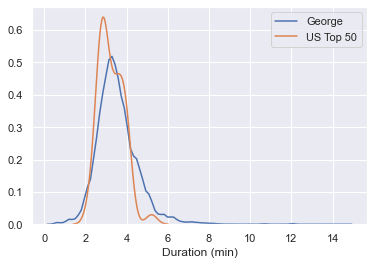

In [110]:
sns.distplot((merged.duration_ms/60000), hist = False, label = 'George')
sns.distplot((df_top50.duration_ms/60000), hist = False, label = 'US Top 50')
plt.xlabel('Duration (min)')
plt.show()

It looks like on average, I listened to songs longer than those present in the Top 50 playlist.

We can replicate these plots for other metrics which don't necessarily have much use other than for comparison.

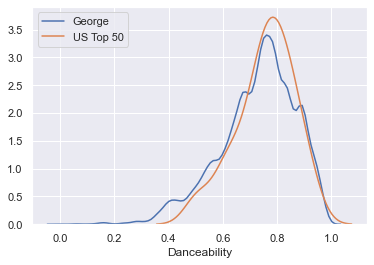

In [146]:
sns.distplot(merged.danceability, hist = False, label = 'George', kde = True)
sns.distplot(df_top50.danceability, hist = False, label = 'US Top 50', kde = True)
plt.xlabel('Danceability')
plt.show()

I guess I dance a little less than the general population

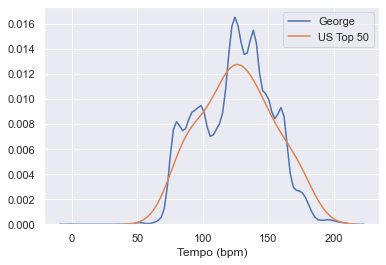

In [151]:
sns.distplot(merged.tempo, hist = False, label = 'George', kde = True)
sns.distplot(df_top50.tempo, hist = False, label = 'US Top 50', kde = True)
plt.xlabel('Tempo (bpm)')
plt.show()

Looks like there's a lot more variability in tempo in my listening history when compared to the Top 50 (although, it should be noted that my listening history is comprised of almost 60k entries and 10k unique songs, whereas the Top 50 playlist only contains 50 distinct entires).  


These metrics do not mean much.  I guess one last thing we can check out is the correlation between any of them.

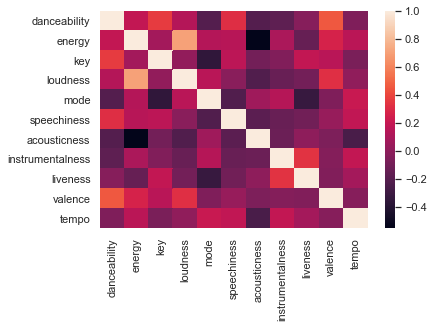

In [201]:
corr_variables = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',]

sns.heatmap(df_top50[corr_variables].corr())

Much of the heatmap is purple, indicating little correlation.  However, there are some spots where slight correlation is observed.  For example, there appears to be a somewhat strong positive correlation between danceability and valence ('happiness').  Additionally, the black square indicates a negative correlation between energy and acoustiness.  

Both of these observations make sense.  However, since we do not know how Spotify calculates these values, the point is moot -- the values may be calculated from the same instrinsic data, making their correlation redundant.

In [202]:
# convert to index.html with cmd line
!jupyter nbconvert to_publish.ipynb --to html --output index.html

[NbConvertApp] Converting notebook to_publish.ipynb to html
[NbConvertApp] Writing 1323717 bytes to index.html
